In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
import seaborn as sns 
import re
import pickle
 
import warnings # supress warnings
warnings.filterwarnings('ignore')

In [2]:
import sklearn

from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, scale, StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.inspection import permutation_importance

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF, Matern, RationalQuadratic,Exponentiation
from sklearn.gaussian_process.kernels import Kernel, Hyperparameter, ConstantKernel
from sklearn.gaussian_process.kernels import GenericKernelMixin

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score  

from sklearn.pipeline import make_pipeline

from sklearn.base import clone

In [3]:
def run_models():
    rf = RandomForestRegressor(n_estimators=10, criterion='absolute_error', 
                               min_samples_split=2, min_samples_leaf=1, max_features=0.3)
    gb = GradientBoostingRegressor(loss='quantile', alpha=0.5,
                                n_estimators=100, max_depth=10,
                                learning_rate=0.25, min_samples_leaf=9,
                                min_samples_split=2)
    rr = Ridge(alpha=0.01)
    lasso = Lasso(alpha=0.02)
    gpr1 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=DotProduct() + WhiteKernel(),
                                    alpha=0.1, n_restarts_optimizer=1)
    gpr2 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RBF(length_scale=1.0), exponent=2) + 
                                    WhiteKernel(noise_level=0.1), alpha=0.1, n_restarts_optimizer=1)
    gpr3 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(RationalQuadratic(length_scale=1.0, 
                                                                                        alpha=0.01), exponent=2),
                                    alpha=0.001, n_restarts_optimizer=1)
    gpr4 = GaussianProcessRegressor(optimizer='fmin_l_bfgs_b',random_state=50,
                                    kernel=1.0 + 1.0 * Exponentiation(Matern(length_scale=1.0, nu=1.5), exponent=2),
                                    alpha=0.01, n_restarts_optimizer=1)
    models = [rf,gb,rr,lasso,gpr1,gpr2,gpr3,gpr4]
    models_names = ["RF","GB","RR","LASSO","gpr1","gpr2","gpr3","gpr4"]
    r2scores=[]
    rmse=[]
    count=0
    for model in models :
        model.fit(X,Y)
        predicted = model.predict(X_test)
        r2=sklearn.metrics.r2_score(Y_test, predicted)
        Y_unscaled = scaler.inverse_transform(np.array(Y_test).reshape(-1,1))
        predicted_unscaled = scaler.inverse_transform(np.array(predicted).reshape(-1,1))
        r2scores.append(r2)
        err=np.sqrt(mean_squared_error(Y_test,predicted))
        err_unscaled=np.sqrt(mean_squared_error(Y_unscaled,predicted_unscaled))
        rmse.append(err_unscaled)
        print(models_names[count],r2)
        print("RMSE: ",err)
        print("RMSE unscaled: ",err_unscaled)
        print("----------------------------------------")
        fig, ax = plt.subplots()
        ax.scatter(Y_unscaled, predicted_unscaled)
        ax.plot([Y_unscaled.min(), predicted_unscaled.max()], [Y_unscaled.min(), predicted_unscaled.max()], 'r--', lw=1)
        #for i in range(len(Y_test)):
        #    plt.annotate(text[i], (Y_test[i], predicted[i]))
        ax.set_xlabel("Calculated, ZPE (kJ/mol))",fontsize= 20)
        ax.set_ylabel("Predicted, ZPE (kJ/mol))",fontsize= 20)
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        ax.tick_params(direction='in', length=10, width=2)
        for axis in ['top','bottom','left','right']:
              ax.spines[axis].set_linewidth(2)
        #plt.savefig('kl_train.eps', format='eps', bbox_inches='tight',pad_inches = 0)
        plt.show()
        count+=1
    plt.rcdefaults()
    fig, ax = plt.subplots()

    x_pos = np.arange(len(models_names))
    ax.bar(x_pos, r2scores, align='center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models_names)
    ax.set_ylabel('R2 Score')
    #plt.savefig('imp.eps', format='eps')
    plt.show()

In [4]:
def get_RF_feature_importance():
    features= X
    feature_list = list(features.columns)
    rf = RandomForestRegressor(n_estimators= 15, random_state=1)
    rf.fit(X , Y)

    # Get numerical feature importances
    importances = list(rf.feature_importances_)      
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, 
                           importance in zip(feature_list, importances)]
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print out the feature and importances 
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

In [5]:
target = 'Coeff_D'

# Standard Scaling

In [6]:
df_test = pd.read_csv('scaled_standard_'+target+'_test.csv', encoding='cp1252')
df_train = pd.read_csv('scaled_standard_'+target+'_train.csv', encoding='cp1252')  

In [7]:
df_test.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_D'], dtype=object)

In [8]:
df_train.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_D'], dtype=object)

In [9]:
df_test.fillna(0, inplace= True)
df_train.fillna(0, inplace= True)

In [10]:
with open("standard_"+target+"_scaler.pkl", 'rb') as file:
        scaler = pickle.load(file)

In [11]:
#df_train.reset_index(inplace = True)
#df_test.reset_index(inplace = True)
#df_train=df_train.drop('index',axis=1)
#df_test=df_test.drop('index',axis=1)

# divide into X_train, y_train, X_test, y_test
Y = df_train[target] 
X = df_train.drop([target,'Name'], axis=1)

Y_test = df_test[target]
X_test = df_test.drop([target,'Name'], axis=1)

RF 0.9330870175534852
RMSE:  0.2598372111344494
RMSE unscaled:  2.7944423416231774
----------------------------------------


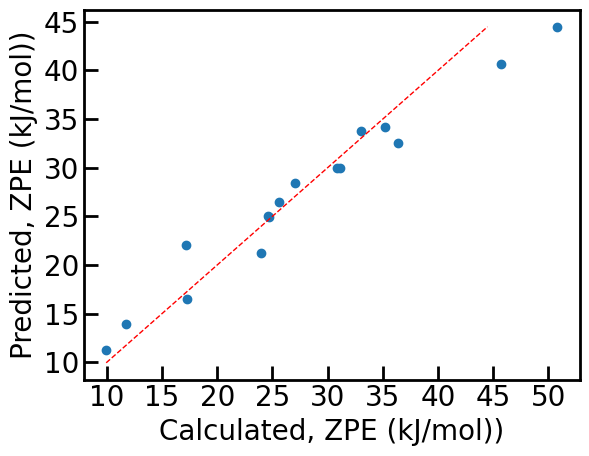

GB 0.8642629431894894
RMSE:  0.3700797878570404
RMSE unscaled:  3.9800559144376004
----------------------------------------


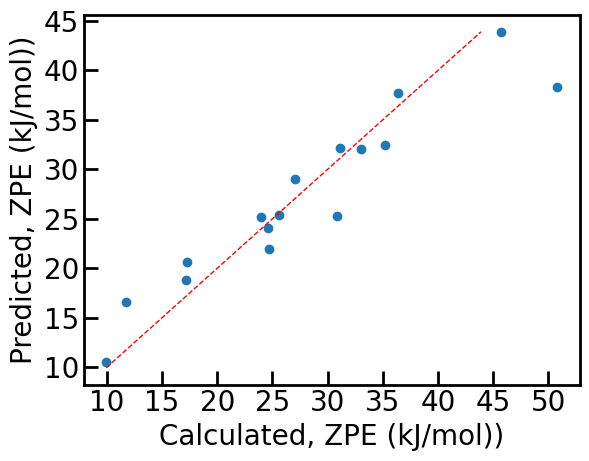

RR 0.9311390520612877
RMSE:  0.26359225827897975
RMSE unscaled:  2.834826329311674
----------------------------------------


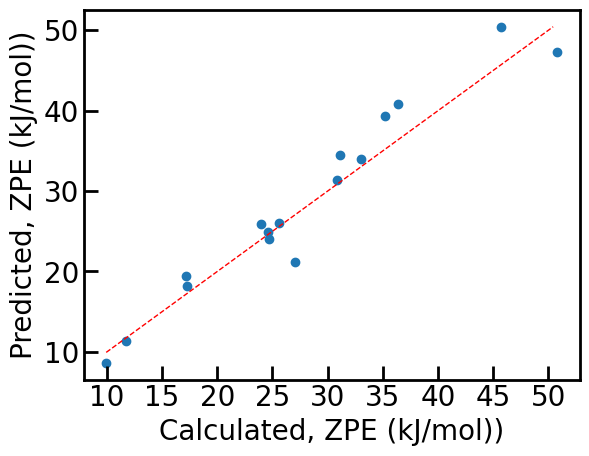

LASSO 0.9503097163198251
RMSE:  0.22391433111022702
RMSE unscaled:  2.4081065410869185
----------------------------------------


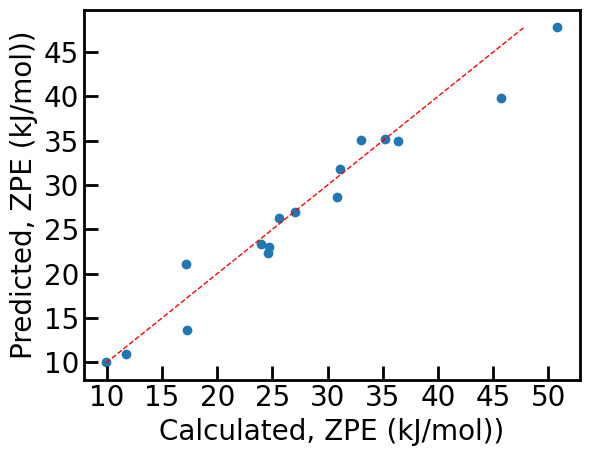

gpr1 0.958464974538824
RMSE:  0.2047167569127408
RMSE unscaled:  2.201644526044164
----------------------------------------


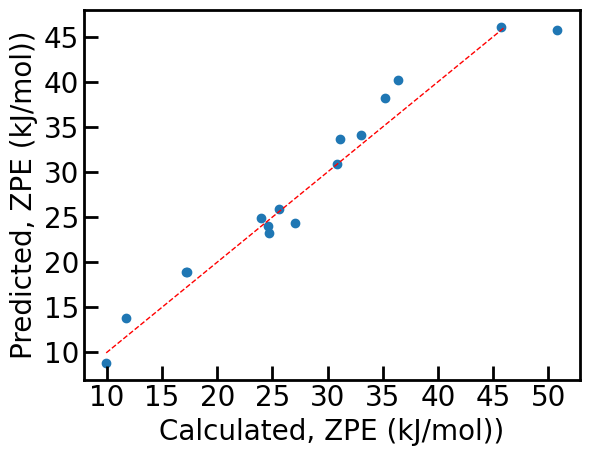

gpr2 0.9645863049071457
RMSE:  0.18903045264396404
RMSE unscaled:  2.0329447749928318
----------------------------------------


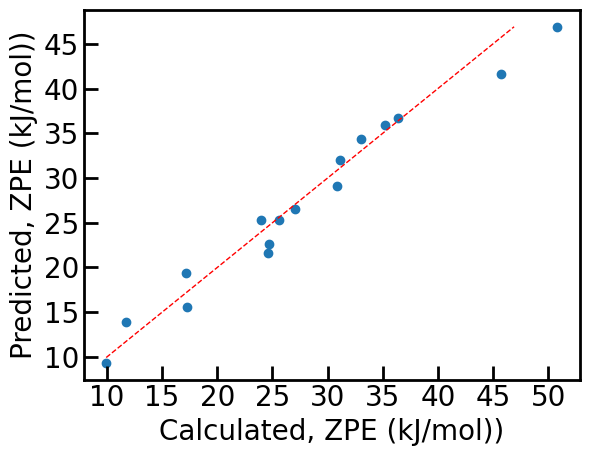

gpr3 0.9460746143964229
RMSE:  0.2332613485345532
RMSE unscaled:  2.508629869306106
----------------------------------------


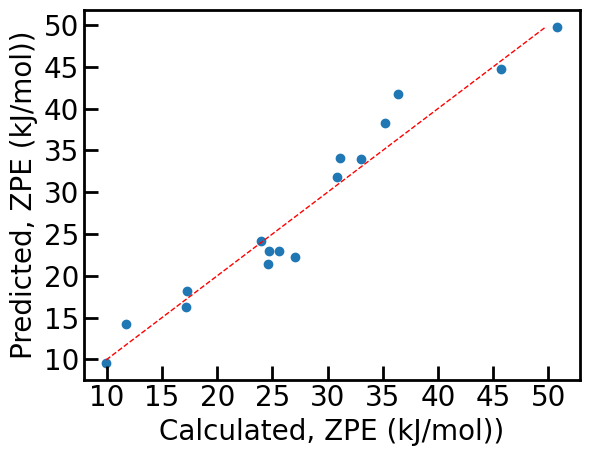

gpr4 0.9632152898905421
RMSE:  0.1926547943997579
RMSE unscaled:  2.071923079981114
----------------------------------------


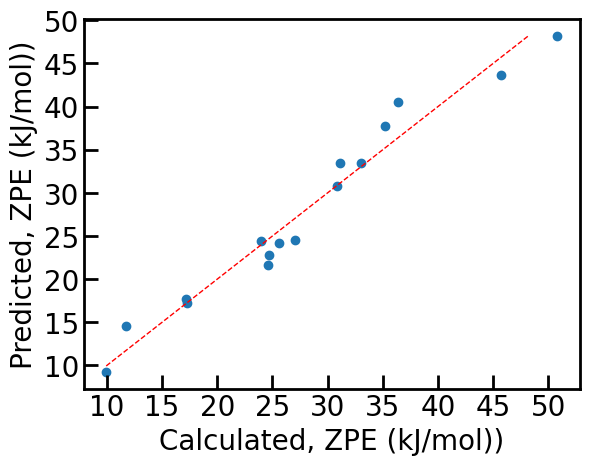

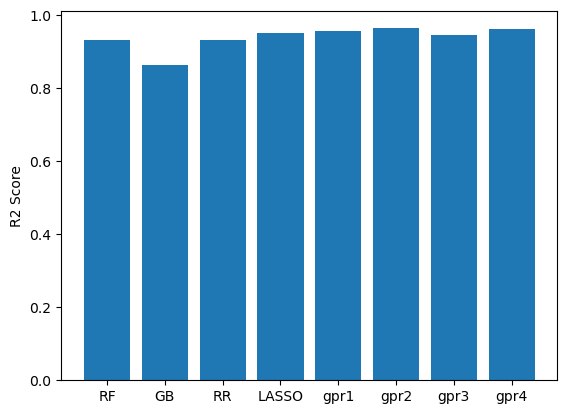

In [12]:
run_models()

In [13]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
26      X_EA  81.327553
34    X_Rvdw  68.872607
14       X_Z  43.716284
1   mean_A2B  36.211892
17       X_G  32.372255
23    X_IEII  26.511620
4   mean_X2X  21.621029
32    A_Rvdw  21.101846
30    A_ChiA  19.421706
18     A_IEI  18.280790
13       B_Z  16.770948
44      B_Hf  16.331228
36      B_Ra  14.649218
2   mean_A2X  14.565069
7    std_B2X  14.088568
11        OF  12.915755
24      A_EA  12.287240
6    std_A2X  10.513584
40     B_Rho   9.918441
9      E_coh   9.383702
27    A_ChiP   9.150204
49     B_CvM   8.540254
38      B_MP   8.085474
35      B_Rc   7.711062
10        TF   6.958592
33    B_Rvdw   6.654667
37      A_MP   5.753776
8    std_X2X   5.651704
45   A_Kappa   5.508368
43      X_MV   5.423308


In [14]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'A_ChiA', 'A_IEI', 'B_Z', 'B_Hf', 'B_Ra', 'mean_A2X',
       'std_B2X', 'OF', 'A_EA', 'std_A2X', 'B_Rho', 'E_coh', 'A_ChiP',
       'B_CvM', 'B_MP', 'B_Rc', 'TF', 'B_Rvdw', 'A_MP', 'std_X2X',
       'A_Kappa', 'X_MV', 'std_A2B', 'B_B', 'A_G', 'A_Z', 'B_MV',
       'X_Kappa', 'A_B', 'X_ChiP', 'B_IEII', 'A_CvM'], dtype=object)

In [15]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.9213976448463885
RMSE:  0.2816202838449446
RMSE unscaled:  3.0287103298266342
----------------------------------------


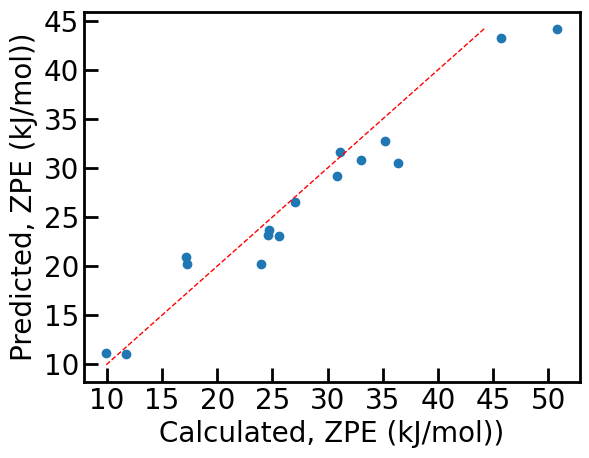

GB 0.7382782930178696
RMSE:  0.5138850986985567
RMSE unscaled:  5.526622889241993
----------------------------------------


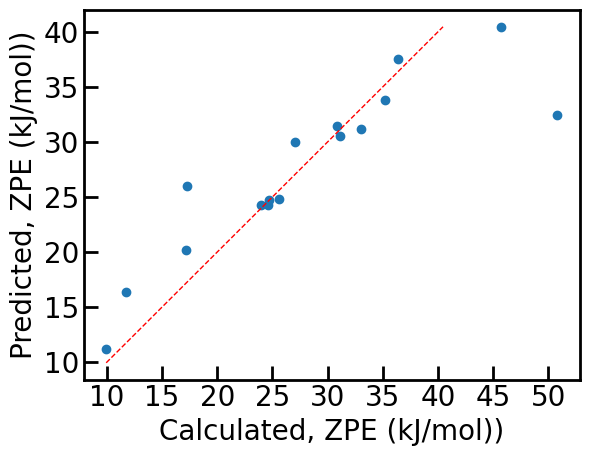

RR 0.8995053378448943
RMSE:  0.3184326929635981
RMSE unscaled:  3.4246126499338634
----------------------------------------


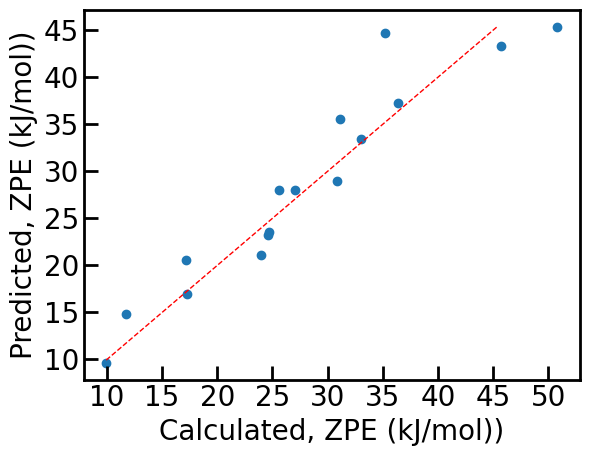

LASSO 0.9502426264919085
RMSE:  0.2240654401963354
RMSE unscaled:  2.40973165716087
----------------------------------------


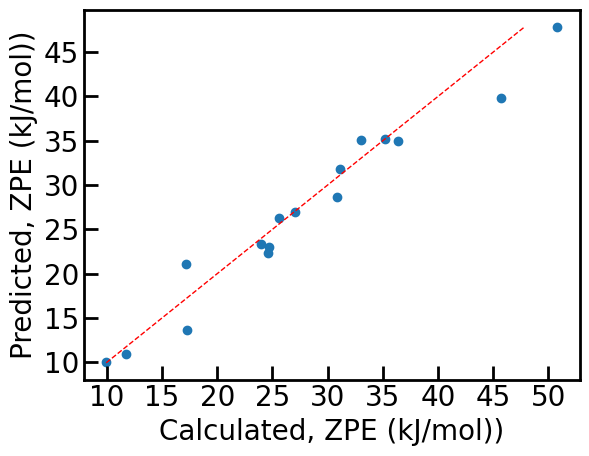

gpr1 0.9226680677975829
RMSE:  0.2793351466510527
RMSE unscaled:  3.004134619122422
----------------------------------------


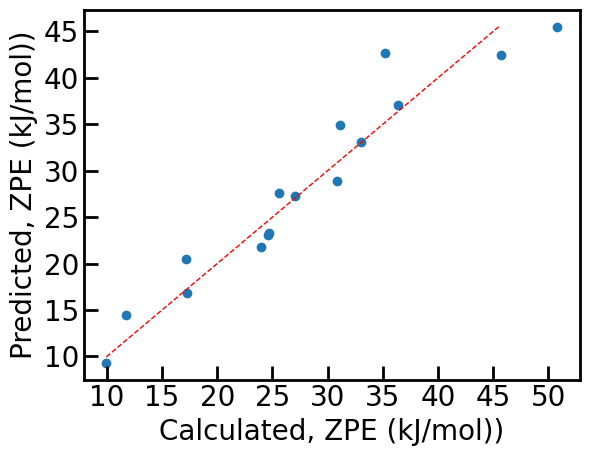

gpr2 0.9670074921396796
RMSE:  0.1824541797397598
RMSE unscaled:  1.9622196645540928
----------------------------------------


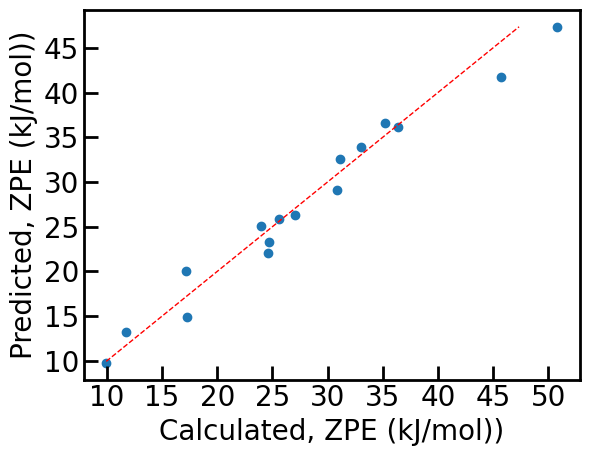

gpr3 0.9641199688044604
RMSE:  0.19027098146582186
RMSE unscaled:  2.0462861522754316
----------------------------------------


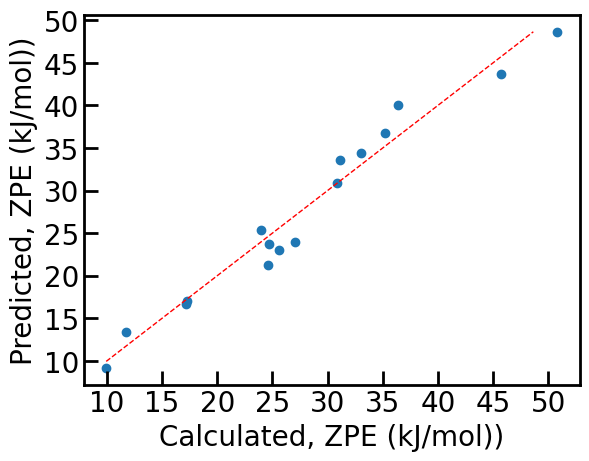

gpr4 0.9691635246113629
RMSE:  0.1763918513915379
RMSE unscaled:  1.8970218164432322
----------------------------------------


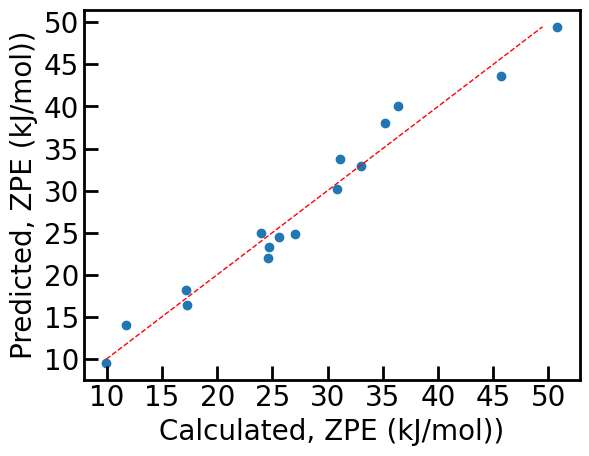

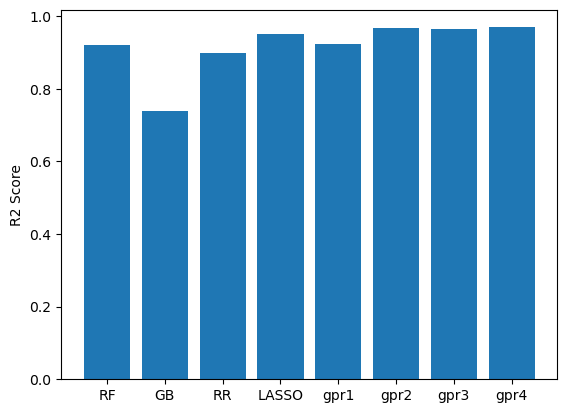

In [16]:
run_models()

In [17]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'A_ChiA', 'A_IEI', 'B_Z', 'B_Hf', 'B_Ra', 'mean_A2X',
       'std_B2X', 'OF', 'A_EA', 'std_A2X', 'B_Rho', 'E_coh', 'A_ChiP',
       'B_CvM', 'B_MP', 'B_Rc', 'TF', 'B_Rvdw', 'A_MP', 'std_X2X',
       'A_Kappa', 'X_MV'], dtype=object)

In [18]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.8995806824589211
RMSE:  0.31831330011985165
RMSE unscaled:  3.4233286290024676
----------------------------------------


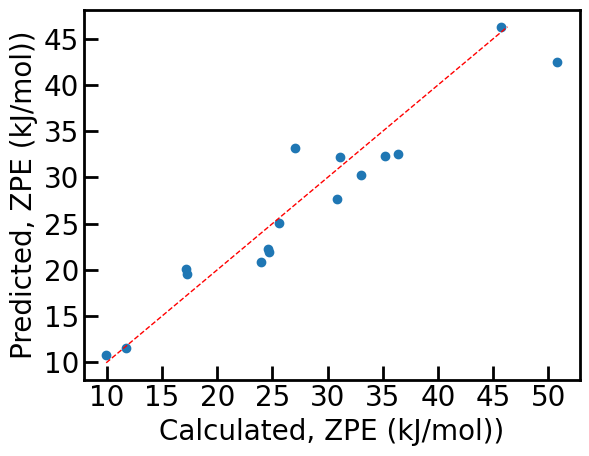

GB 0.7565519341307927
RMSE:  0.4956205629744685
RMSE unscaled:  5.330195319246748
----------------------------------------


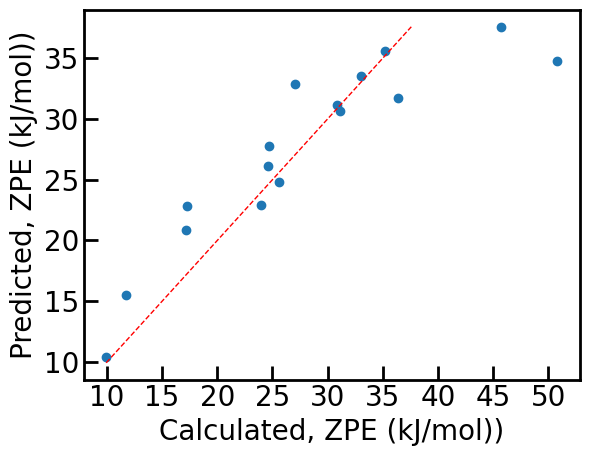

RR 0.9367594169809559
RMSE:  0.25260624606963794
RMSE unscaled:  2.716676286254566
----------------------------------------


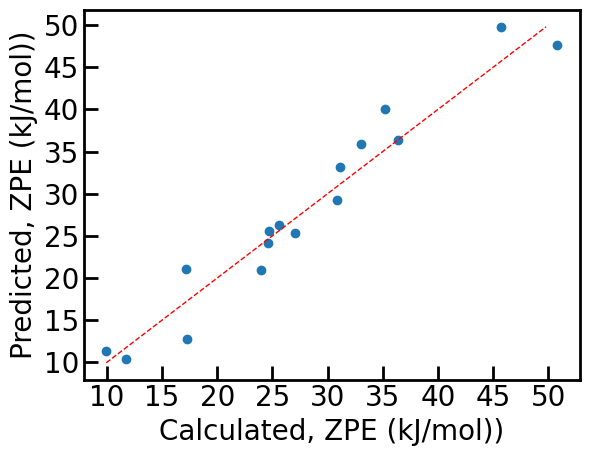

LASSO 0.9333294806309633
RMSE:  0.2593660162850512
RMSE unscaled:  2.7893748348077976
----------------------------------------


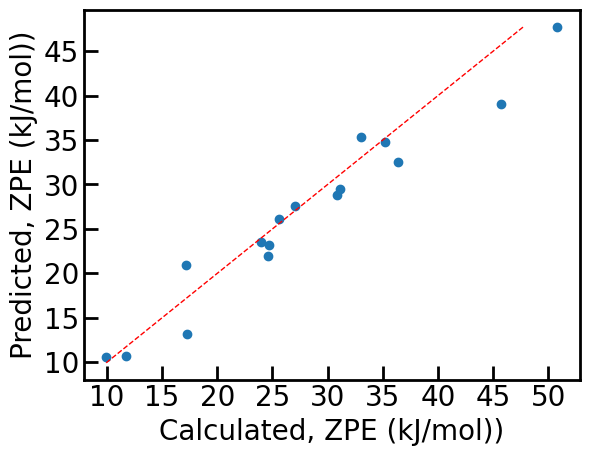

gpr1 0.9551535128931815
RMSE:  0.21272100065806576
RMSE unscaled:  2.2877268755927624
----------------------------------------


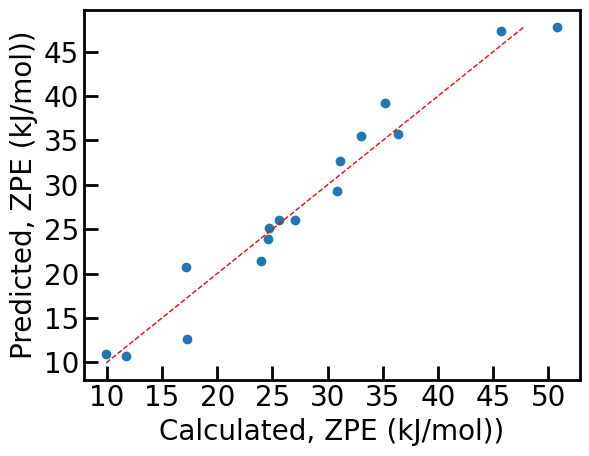

gpr2 0.9546461511822963
RMSE:  0.2139209046104442
RMSE unscaled:  2.300631349112039
----------------------------------------


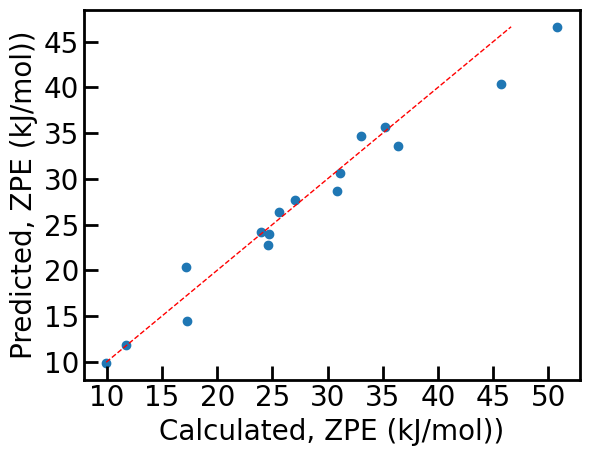

gpr3 0.9753545286439702
RMSE:  0.1576938356172414
RMSE unscaled:  1.6959323467868013
----------------------------------------


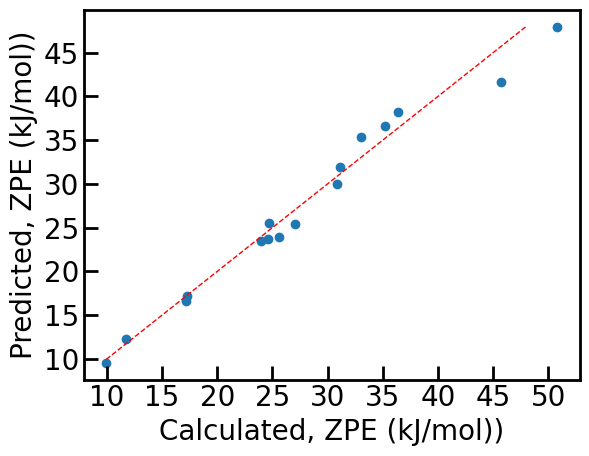

gpr4 0.9817620896958824
RMSE:  0.13565433918859585
RMSE unscaled:  1.4589066269548874
----------------------------------------


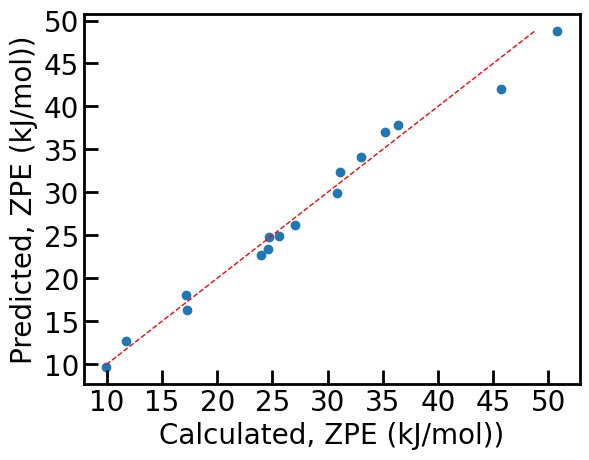

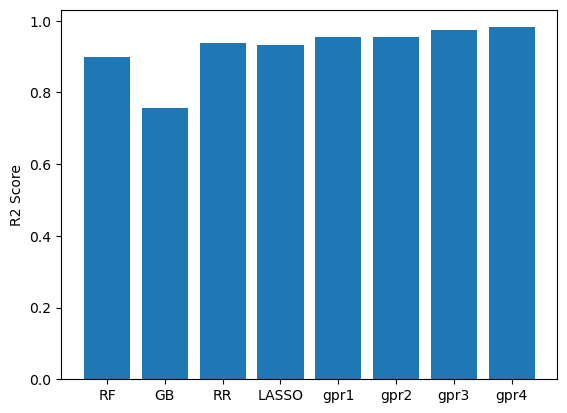

In [19]:
run_models()

In [20]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'A_ChiA', 'A_IEI', 'B_Z', 'B_Hf', 'B_Ra', 'mean_A2X',
       'std_B2X', 'OF', 'A_EA', 'std_A2X', 'B_Rho', 'E_coh'], dtype=object)

In [21]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.7858204088910258
RMSE:  0.46487393343530103
RMSE unscaled:  4.999527963823227
----------------------------------------


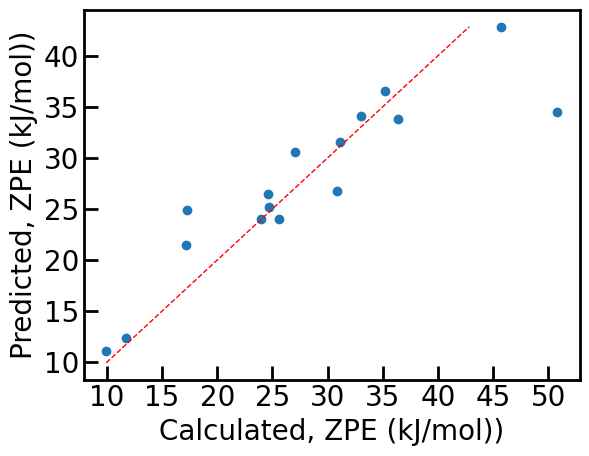

GB 0.7190815901833006
RMSE:  0.5323978010891779
RMSE unscaled:  5.725719389671456
----------------------------------------


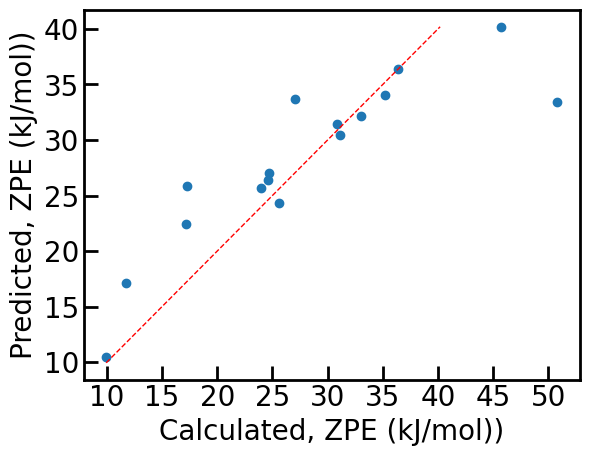

RR 0.9403270921576075
RMSE:  0.2453775088771559
RMSE unscaled:  2.6389341907365926
----------------------------------------


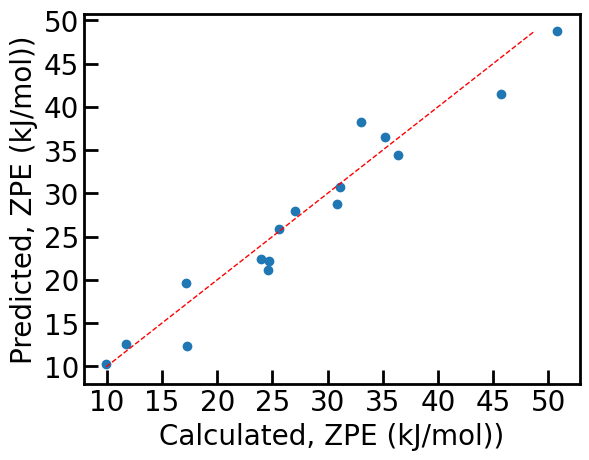

LASSO 0.9306407274437491
RMSE:  0.26454430532880885
RMSE unscaled:  2.8450652037809787
----------------------------------------


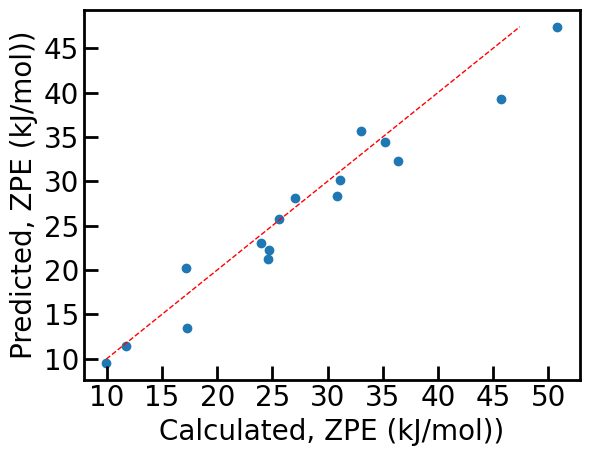

gpr1 0.9442952230475752
RMSE:  0.23707860995476035
RMSE unscaled:  2.549682945942432
----------------------------------------


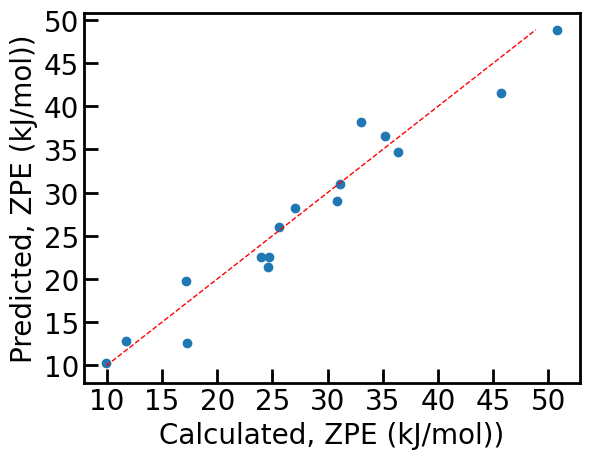

gpr2 0.9508764840021631
RMSE:  0.22263368475102518
RMSE unscaled:  2.394333716189458
----------------------------------------


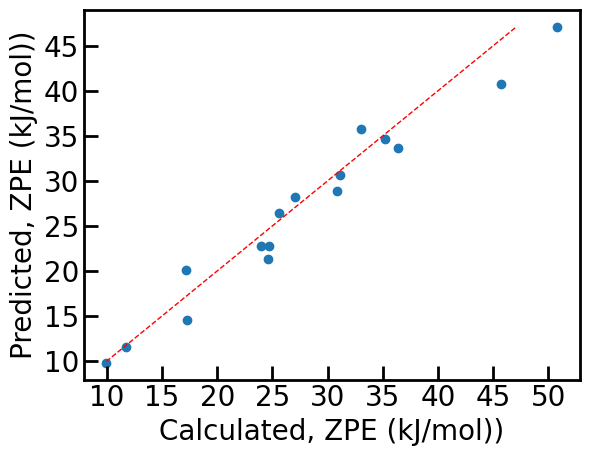

gpr3 0.9692943471300906
RMSE:  0.1760172859973697
RMSE unscaled:  1.892993519677728
----------------------------------------


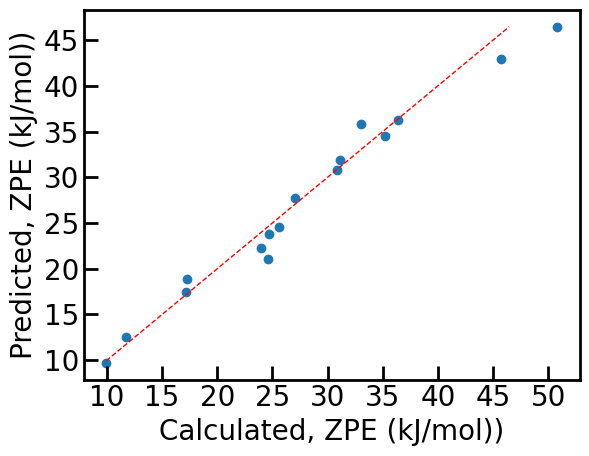

gpr4 0.9705319545221783
RMSE:  0.17243356934623186
RMSE unscaled:  1.8544521209819966
----------------------------------------


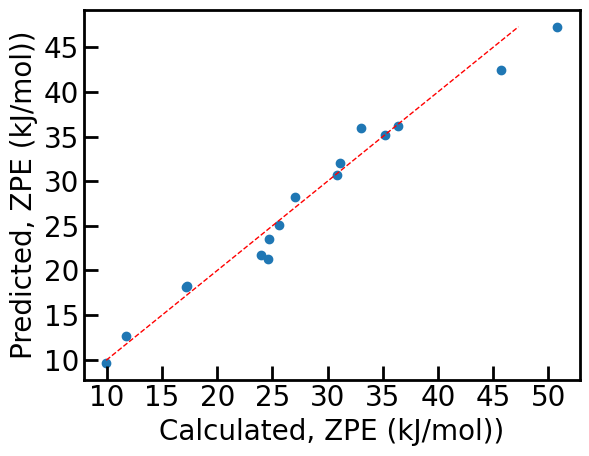

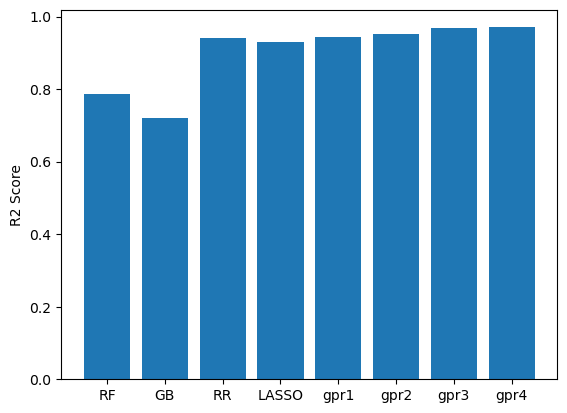

In [22]:
run_models()

In [23]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'X_IEII', 'mean_X2X',
       'A_Rvdw', 'A_ChiA', 'A_IEI'], dtype=object)

In [24]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8254554347791195
RMSE:  0.41966168281361266
RMSE unscaled:  4.513288802982055
----------------------------------------


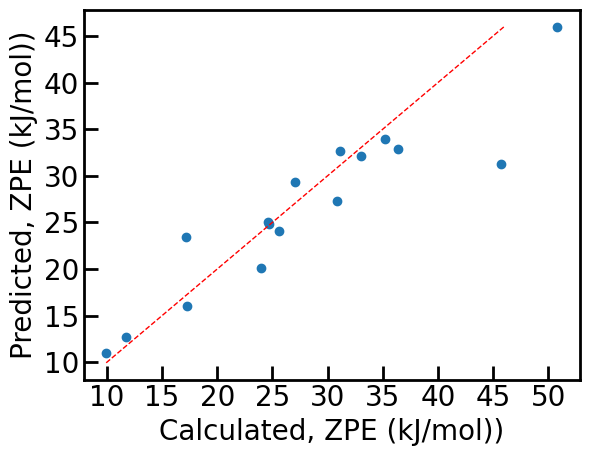

GB 0.615948669031599
RMSE:  0.6225020553050905
RMSE unscaled:  6.6947535862824985
----------------------------------------


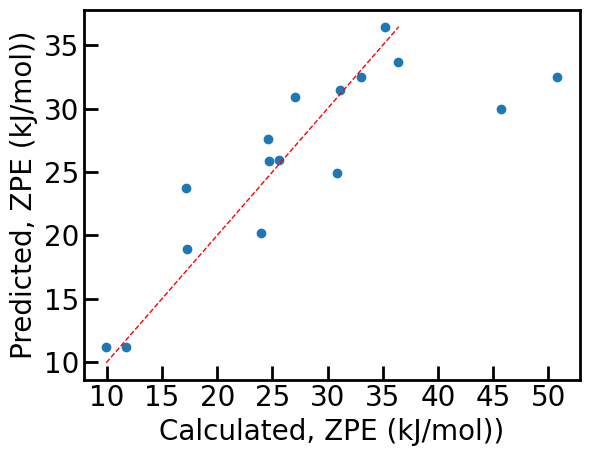

RR 0.8303916061868075
RMSE:  0.4136850468825125
RMSE unscaled:  4.44901254157433
----------------------------------------


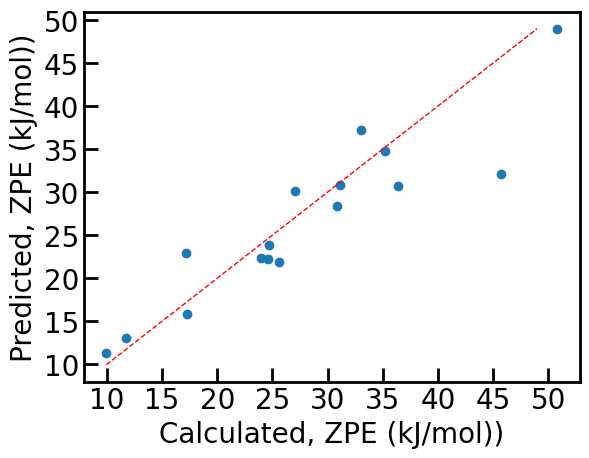

LASSO 0.8247610020721574
RMSE:  0.42049567472237614
RMSE unscaled:  4.522258042962138
----------------------------------------


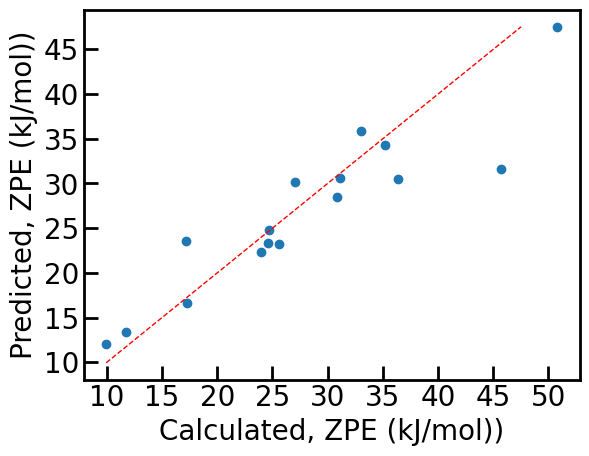

gpr1 0.8346824780222118
RMSE:  0.40841867854180347
RMSE unscaled:  4.392374915987106
----------------------------------------


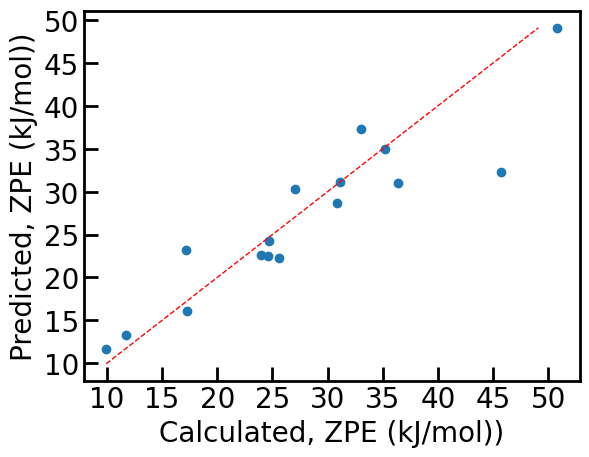

gpr2 0.8308649771318964
RMSE:  0.41310735345477345
RMSE unscaled:  4.442799686348922
----------------------------------------


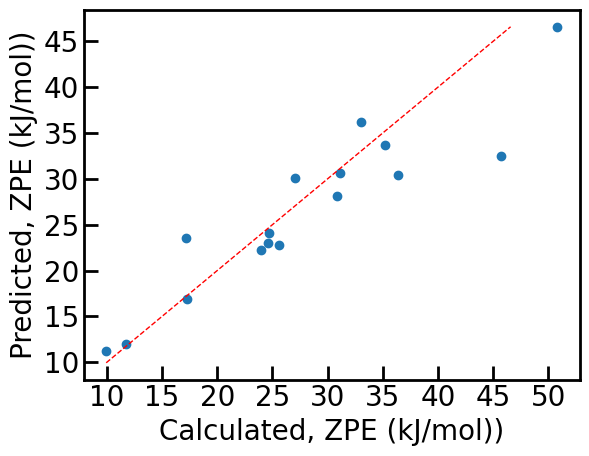

gpr3 0.7610735222408596
RMSE:  0.49099638295952736
RMSE unscaled:  5.280464164988197
----------------------------------------


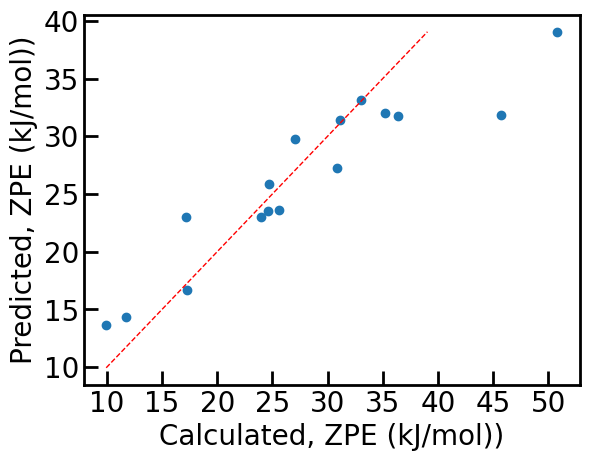

gpr4 0.050524828982534076
RMSE:  0.9787864727080262
RMSE unscaled:  10.526445965154824
----------------------------------------


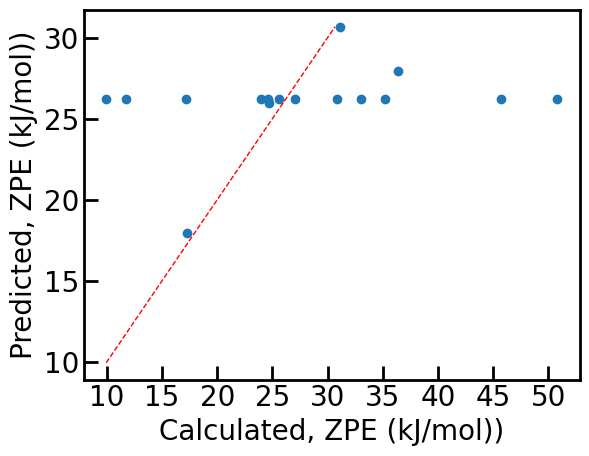

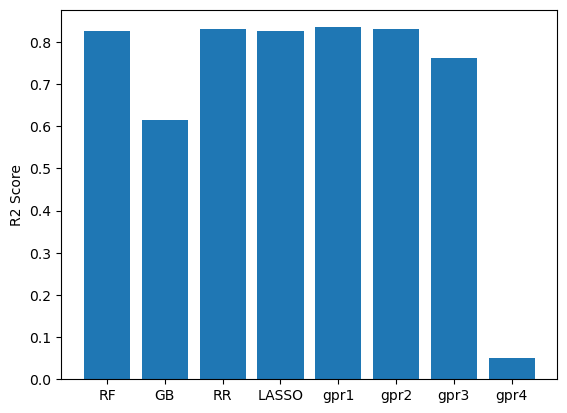

In [25]:
run_models()

# Min-Max scaling

In [26]:
df_test = pd.read_csv('scaled_minmax_'+target+'_test.csv', encoding='cp1252')
df_train = pd.read_csv('scaled_minmax_'+target+'_train.csv', encoding='cp1252')   

In [27]:
df_test.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_D'], dtype=object)

In [28]:
df_train.columns.values

array(['Name', 'density', 'mean_A2B', 'mean_A2X', 'mean_B2X', 'mean_X2X',
       'std_A2B', 'std_A2X', 'std_B2X', 'std_X2X', 'E_coh', 'TF', 'OF',
       'A_Z', 'B_Z', 'X_Z', 'A_G', 'B_G', 'X_G', 'A_IEI', 'B_IEI',
       'X_IEI', 'A_IEII', 'B_IEII', 'X_IEII', 'A_EA', 'B_EA', 'X_EA',
       'A_ChiP', 'B_ChiP', 'X_ChiP', 'A_ChiA', 'B_ChiA', 'A_Rvdw',
       'B_Rvdw', 'X_Rvdw', 'B_Rc', 'B_Ra', 'A_MP', 'B_MP', 'A_Rho',
       'B_Rho', 'X_Rho', 'B_MV', 'X_MV', 'B_Hf', 'A_Kappa', 'B_Kappa',
       'X_Kappa', 'A_CvM', 'B_CvM', 'A_B', 'B_B', 'B_MendeleevNo',
       'Coeff_D'], dtype=object)

In [29]:
df_test.fillna(0, inplace= True)
df_train.fillna(0, inplace= True)

In [30]:
with open("minmax_"+target+"_scaler.pkl", 'rb') as file:
        scaler = pickle.load(file)

In [31]:
#df_train.reset_index(inplace = True)
#df_test.reset_index(inplace = True)
#df_train=df_train.drop('index',axis=1)
#df_test=df_test.drop('index',axis=1)
# divide into X_train, y_train, X_test, y_test
Y = df_train[target] 
X = df_train.drop([target,'Name'], axis=1)

Y_test = df_test[target]
X_test = df_test.drop([target,'Name'], axis=1)

RF 0.93990863220876
RMSE:  0.05661508854223446
RMSE unscaled:  2.648170870264862
----------------------------------------


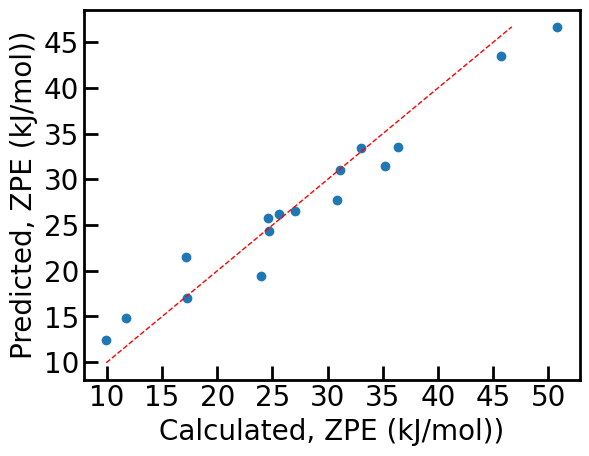

GB 0.8299652986804908
RMSE:  0.09523463629751237
RMSE unscaled:  4.454600287257406
----------------------------------------


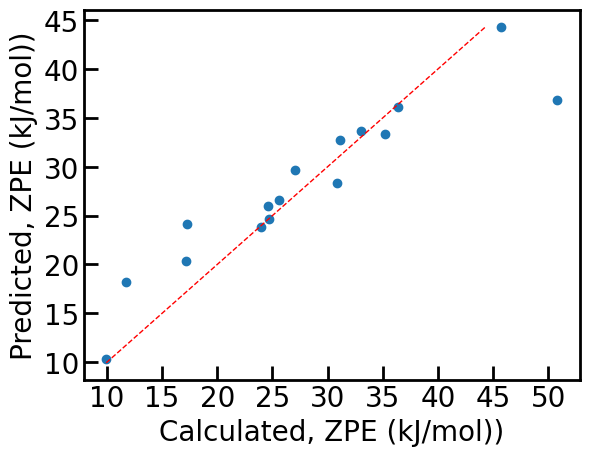

RR 0.9654175316428357
RMSE:  0.04294910718288792
RMSE unscaled:  2.008944567149455
----------------------------------------


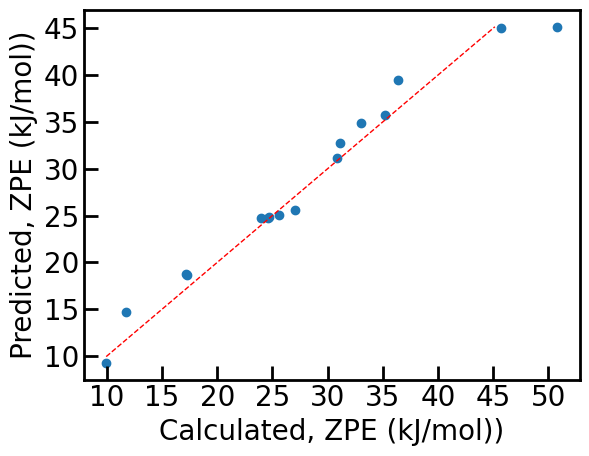

LASSO 0.5747644626658129
RMSE:  0.15060553112056296
RMSE unscaled:  7.044573994028456
----------------------------------------


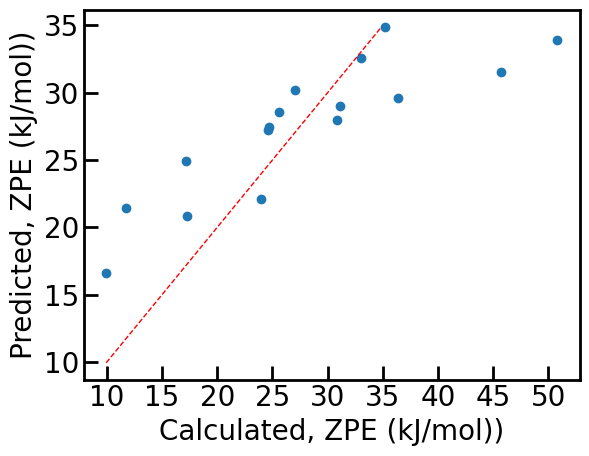

gpr1 0.9434677904450527
RMSE:  0.054912867933392444
RMSE unscaled:  2.5685494981683217
----------------------------------------


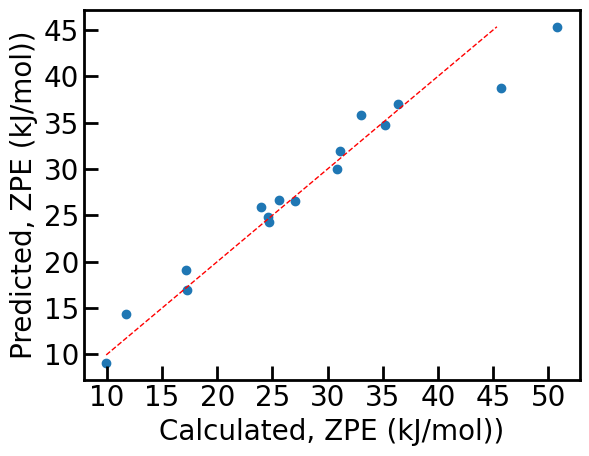

gpr2 -0.04344582545281961
RMSE:  0.23591801154490294
RMSE unscaled:  11.035065422143811
----------------------------------------


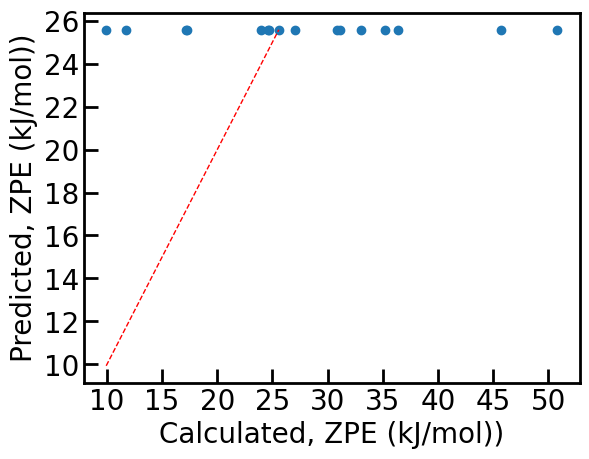

gpr3 0.9597465417753638
RMSE:  0.04633698206044186
RMSE unscaled:  2.1674124207526098
----------------------------------------


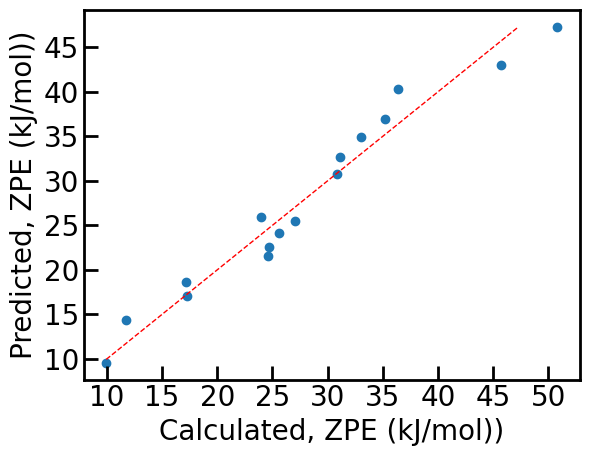

gpr4 0.9486519079667514
RMSE:  0.052334526786148534
RMSE unscaled:  2.447947586283242
----------------------------------------


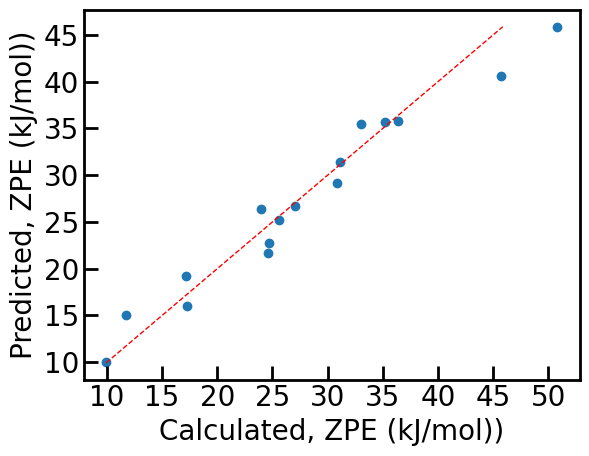

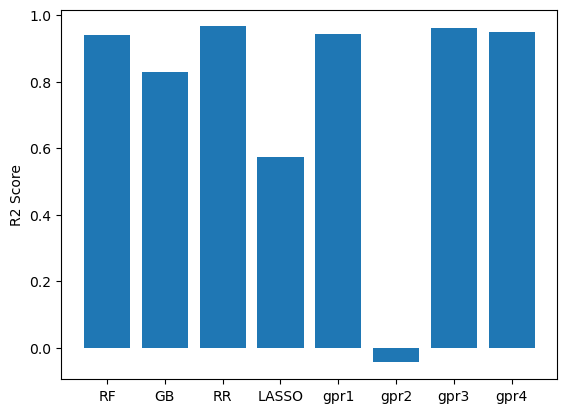

In [32]:
run_models()

## Feature selection


In [33]:
#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']  #naming the dataframe columns
print(featureScores.nlargest(30,'Score'))  #print 10 best features

     Feature      Score
26      X_EA  81.327553
34    X_Rvdw  68.872607
14       X_Z  43.716284
1   mean_A2B  36.211892
17       X_G  32.372255
4   mean_X2X  21.621029
32    A_Rvdw  21.101846
30    A_ChiA  18.696214
18     A_IEI  18.280790
13       B_Z  16.770948
44      B_Hf  16.331228
36      B_Ra  14.649218
2   mean_A2X  14.565069
7    std_B2X  14.088568
11        OF  12.915755
24      A_EA  12.287240
6    std_A2X  10.513584
40     B_Rho   9.615471
9      E_coh   9.383702
27    A_ChiP   9.150204
49     B_CvM   8.540254
38      B_MP   8.085474
35      B_Rc   7.711062
10        TF   6.958592
41     X_Rho   6.855010
33    B_Rvdw   6.654667
31    B_ChiA   6.505637
37      A_MP   5.753776
8    std_X2X   5.651704
45   A_Kappa   5.508368


In [34]:
featureScores.nlargest(40,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'A_ChiA', 'A_IEI', 'B_Z', 'B_Hf', 'B_Ra', 'mean_A2X', 'std_B2X',
       'OF', 'A_EA', 'std_A2X', 'B_Rho', 'E_coh', 'A_ChiP', 'B_CvM',
       'B_MP', 'B_Rc', 'TF', 'X_Rho', 'B_Rvdw', 'B_ChiA', 'A_MP',
       'std_X2X', 'A_Kappa', 'X_MV', 'std_A2B', 'B_B', 'A_G', 'A_Z',
       'X_IEII', 'B_MV', 'X_Kappa', 'A_B', 'X_ChiP'], dtype=object)

In [35]:
X=X[featureScores.nlargest(40,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(40,'Score')['Feature'].values]

RF 0.8756711152064961
RMSE:  0.08143519960074617
RMSE unscaled:  3.8091316104897412
----------------------------------------


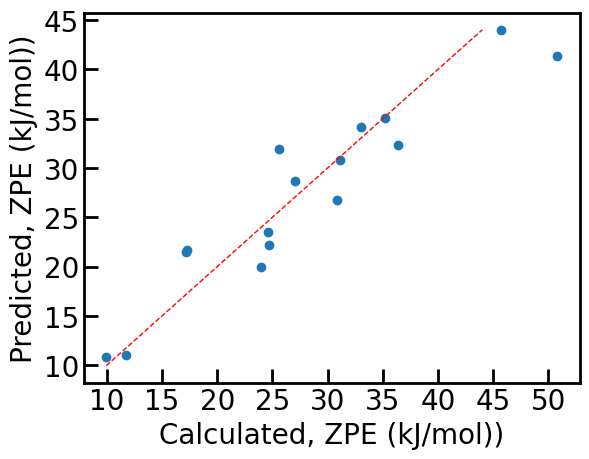

GB 0.7561123798056322
RMSE:  0.11405675832991431
RMSE unscaled:  5.335005079799485
----------------------------------------


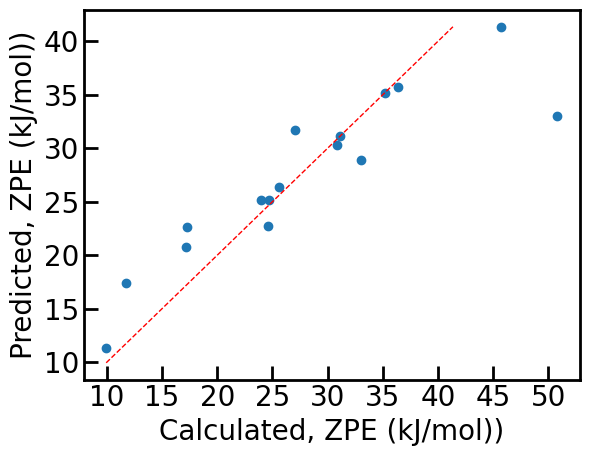

RR 0.9736871690334897
RMSE:  0.037463636766519766
RMSE unscaled:  1.7523616783760991
----------------------------------------


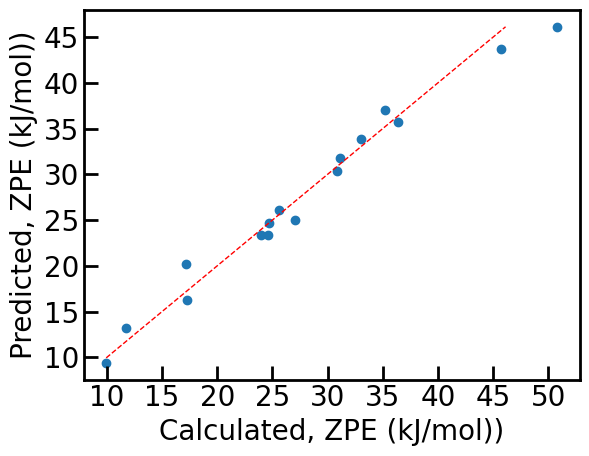

LASSO 0.5747623874105687
RMSE:  0.15060589861635
RMSE unscaled:  7.044591183644565
----------------------------------------


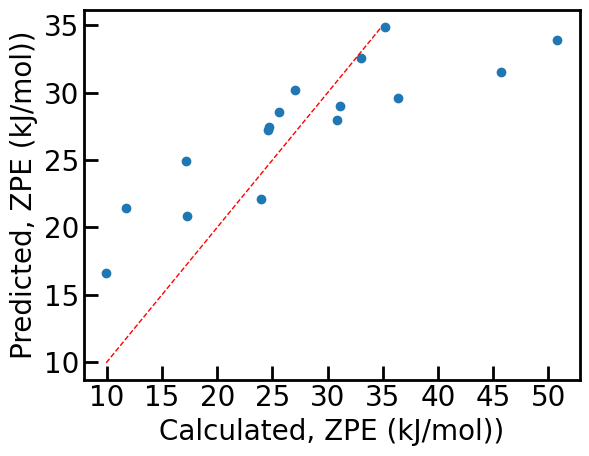

gpr1 0.8953199959414152
RMSE:  0.07472363863614277
RMSE unscaled:  3.495198334076853
----------------------------------------


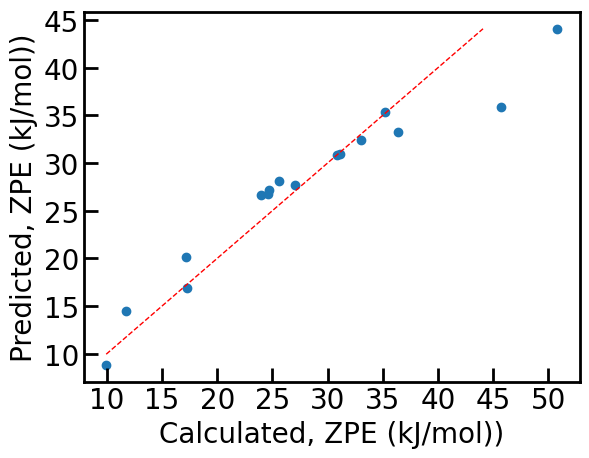

gpr2 -0.0434458211058224
RMSE:  0.2359180110534855
RMSE unscaled:  11.03506539915776
----------------------------------------


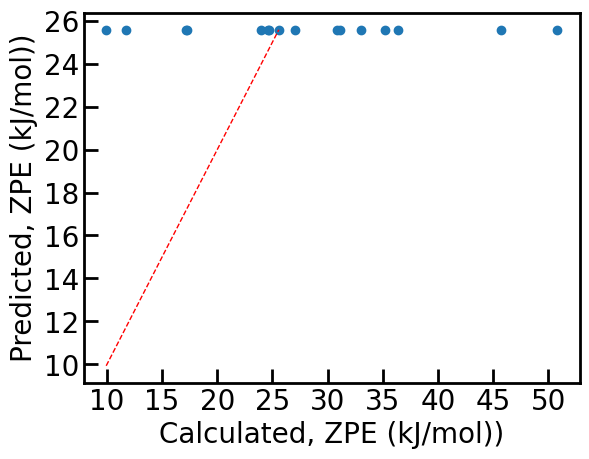

gpr3 0.9690301699890317
RMSE:  0.04064391710322147
RMSE unscaled:  1.9011192969506403
----------------------------------------


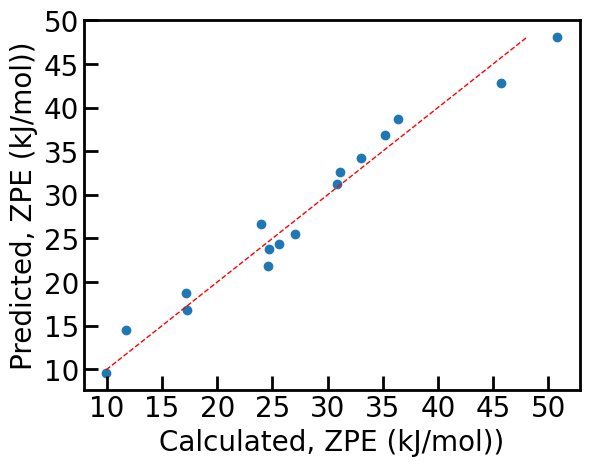

gpr4 0.9469429590469972
RMSE:  0.05319828830304057
RMSE unscaled:  2.488350032818018
----------------------------------------


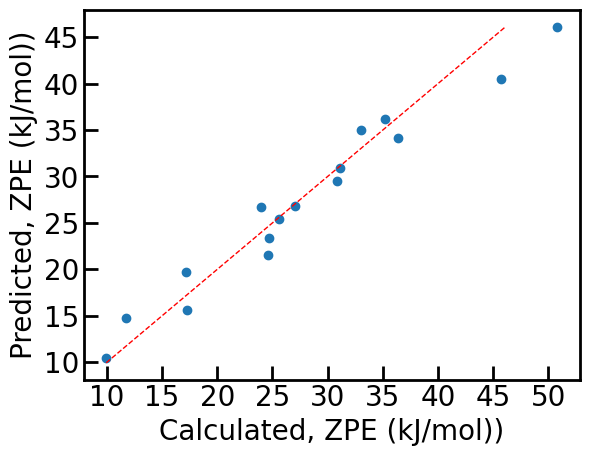

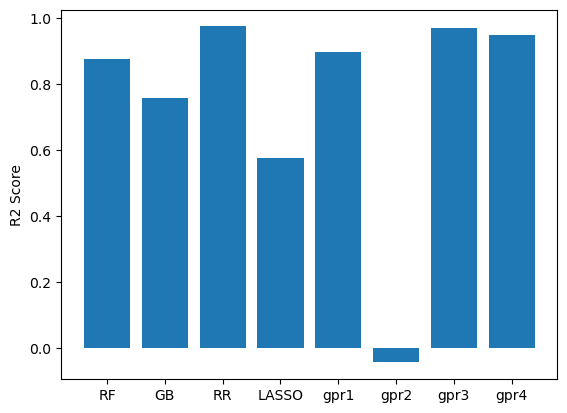

In [36]:
run_models()

In [37]:
featureScores.nlargest(30,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'A_ChiA', 'A_IEI', 'B_Z', 'B_Hf', 'B_Ra', 'mean_A2X', 'std_B2X',
       'OF', 'A_EA', 'std_A2X', 'B_Rho', 'E_coh', 'A_ChiP', 'B_CvM',
       'B_MP', 'B_Rc', 'TF', 'X_Rho', 'B_Rvdw', 'B_ChiA', 'A_MP',
       'std_X2X', 'A_Kappa'], dtype=object)

In [38]:
X=X[featureScores.nlargest(30,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(30,'Score')['Feature'].values]

RF 0.9255817837165021
RMSE:  0.06300365928942628
RMSE unscaled:  2.946996278666705
----------------------------------------


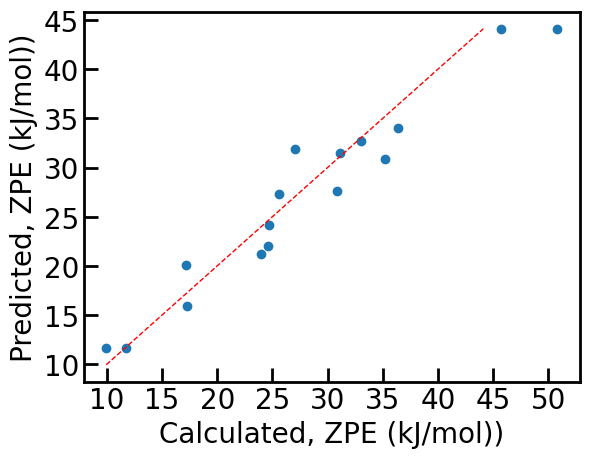

GB 0.7263388809418339
RMSE:  0.12081829298783082
RMSE unscaled:  5.651275875808633
----------------------------------------


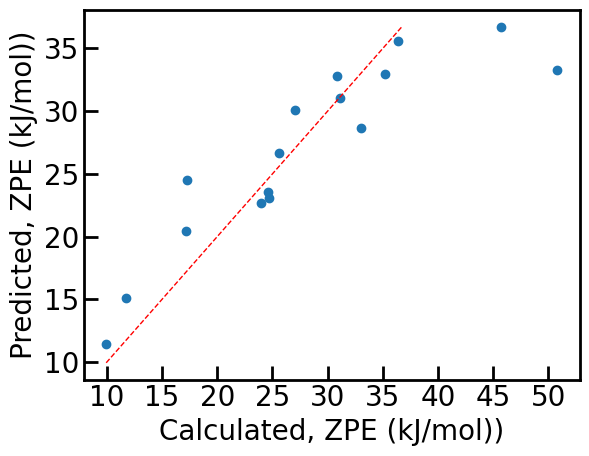

RR 0.9523649934299633
RMSE:  0.05040681544460446
RMSE unscaled:  2.3577788847515295
----------------------------------------


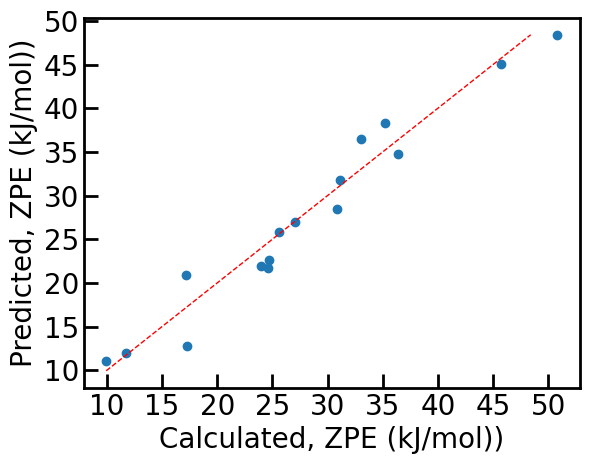

LASSO 0.5747623874105687
RMSE:  0.15060589861635
RMSE unscaled:  7.044591183644565
----------------------------------------


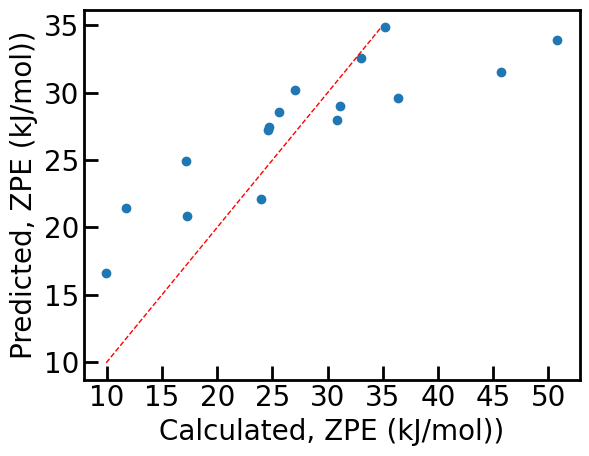

gpr1 0.8769848572578319
RMSE:  0.08100380762054551
RMSE unscaled:  3.7889532498256755
----------------------------------------


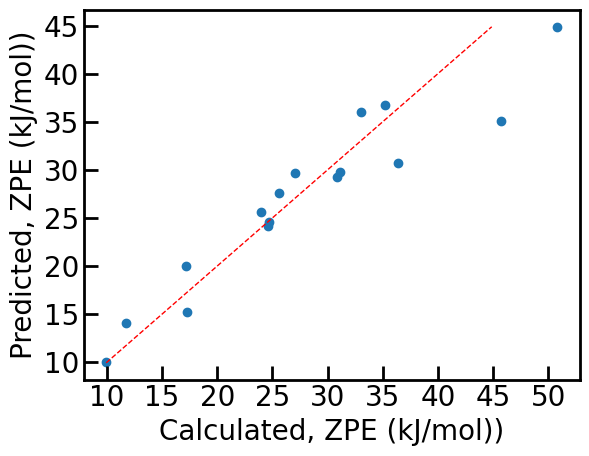

gpr2 -0.04344581818274462
RMSE:  0.23591801072303867
RMSE unscaled:  11.03506538370111
----------------------------------------


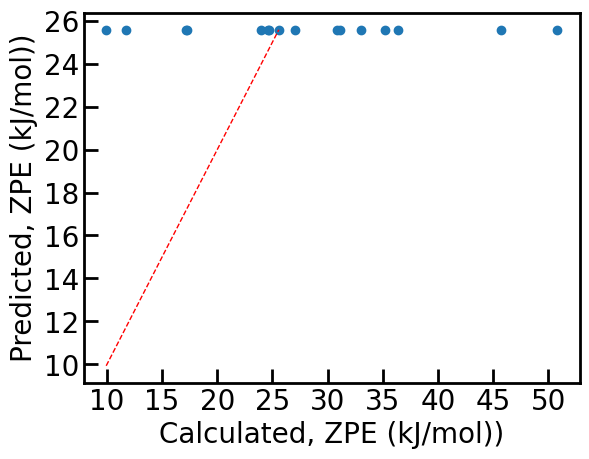

gpr3 0.9726939576073429
RMSE:  0.03816414402974101
RMSE unscaled:  1.785127906896392
----------------------------------------


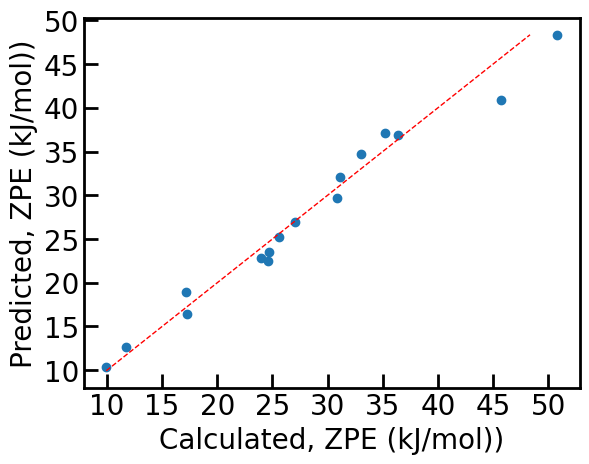

gpr4 0.9323708933598346
RMSE:  0.060061057059502695
RMSE unscaled:  2.809356053972067
----------------------------------------


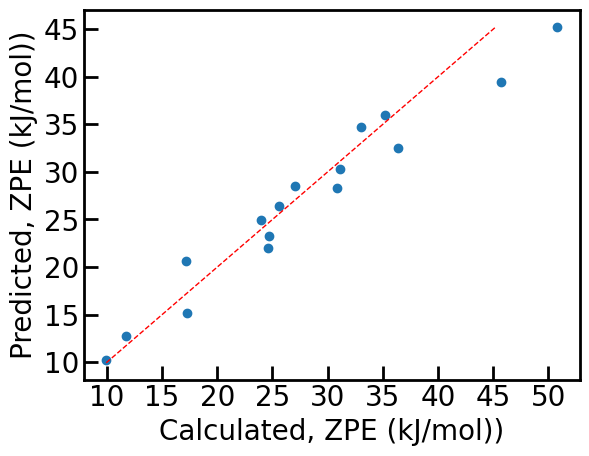

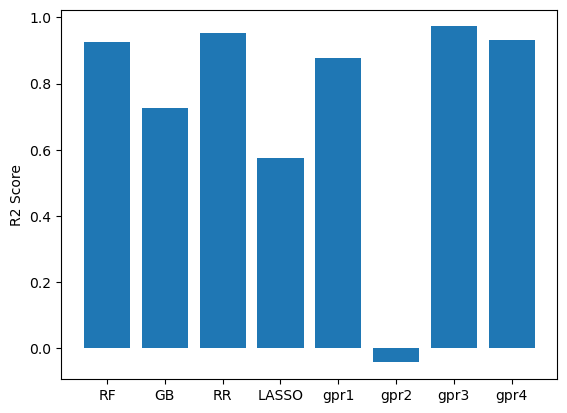

In [39]:
run_models()

In [40]:
featureScores.nlargest(20,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'A_ChiA', 'A_IEI', 'B_Z', 'B_Hf', 'B_Ra', 'mean_A2X', 'std_B2X',
       'OF', 'A_EA', 'std_A2X', 'B_Rho', 'E_coh', 'A_ChiP'], dtype=object)

In [41]:
X=X[featureScores.nlargest(20,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(20,'Score')['Feature'].values]

RF 0.8526849169719691
RMSE:  0.08864408337658637
RMSE unscaled:  4.146327162309178
----------------------------------------


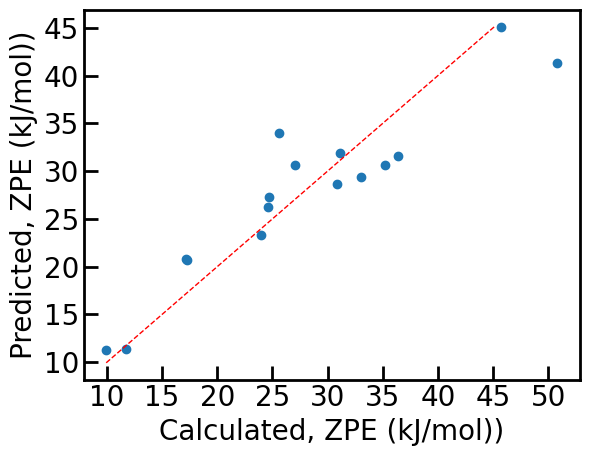

GB 0.7698377435923462
RMSE:  0.11080087738183886
RMSE unscaled:  5.182711242489457
----------------------------------------


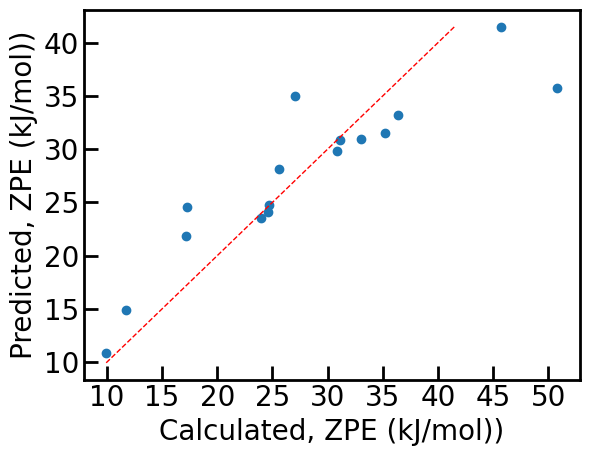

RR 0.9432412484297321
RMSE:  0.05502278433302827
RMSE unscaled:  2.573690837962621
----------------------------------------


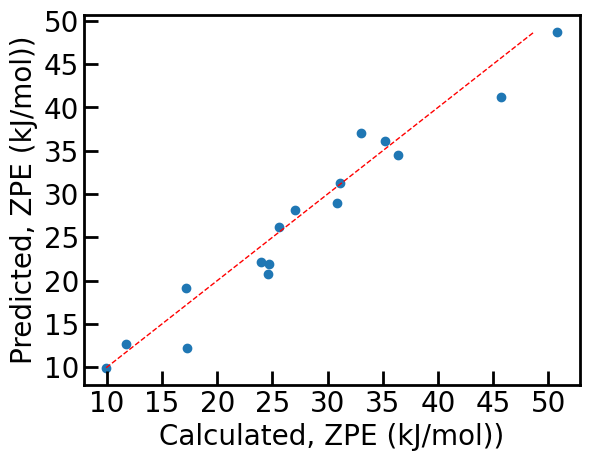

LASSO 0.5747623874105687
RMSE:  0.15060589861635
RMSE unscaled:  7.044591183644565
----------------------------------------


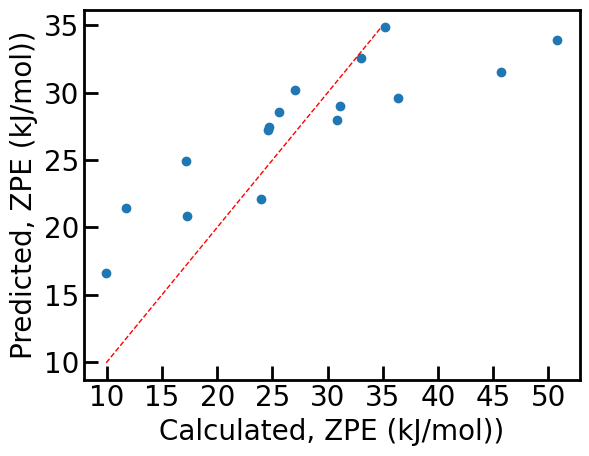

gpr1 0.9208035060644256
RMSE:  0.06499487665806293
RMSE unscaled:  3.0401354747319975
----------------------------------------


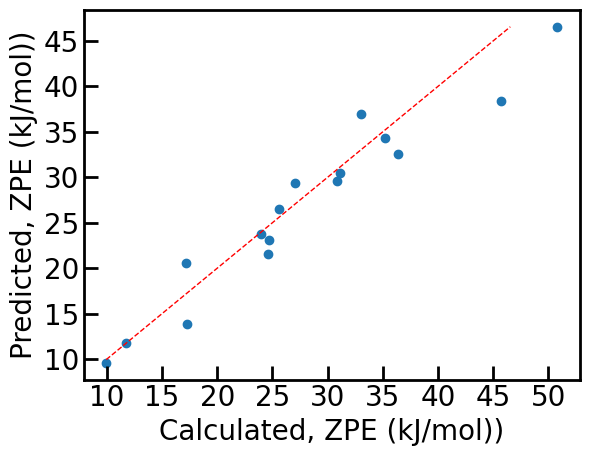

gpr2 -0.043445708301718566
RMSE:  0.2359179983012563
RMSE unscaled:  11.035064802672215
----------------------------------------


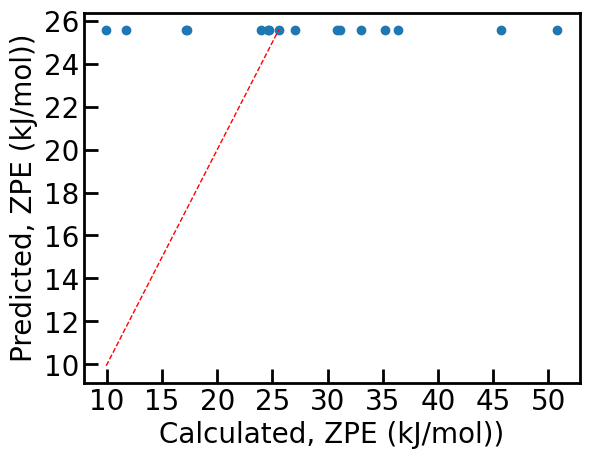

gpr3 0.9561278230706017
RMSE:  0.04837497330823304
RMSE unscaled:  2.2627394651010304
----------------------------------------


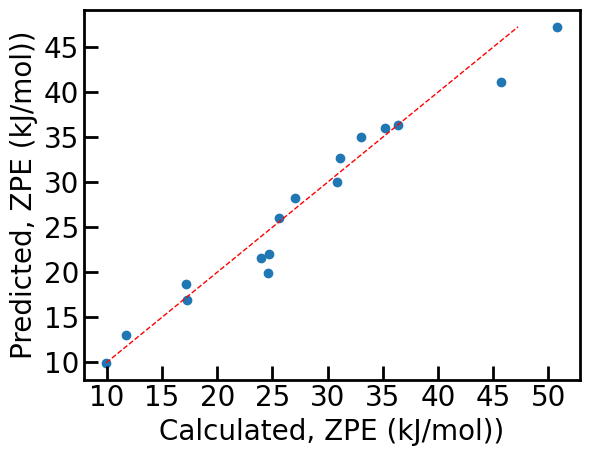

gpr4 0.9433114347676378
RMSE:  0.05498875396564276
RMSE unscaled:  2.572099067465831
----------------------------------------


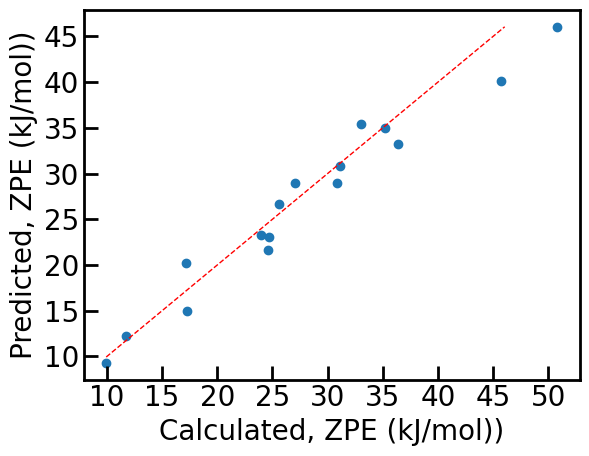

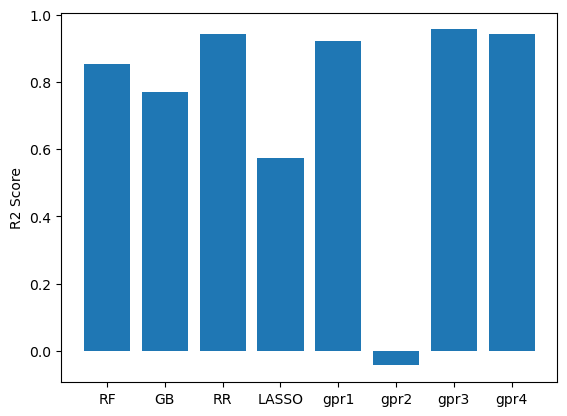

In [42]:
run_models()

In [43]:
featureScores.nlargest(10,'Score')['Feature'].values

array(['X_EA', 'X_Rvdw', 'X_Z', 'mean_A2B', 'X_G', 'mean_X2X', 'A_Rvdw',
       'A_ChiA', 'A_IEI', 'B_Z'], dtype=object)

In [44]:
X=X[featureScores.nlargest(10,'Score')['Feature'].values]
X_test=X_test[featureScores.nlargest(10,'Score')['Feature'].values]

RF 0.8784983119679919
RMSE:  0.08050397076204689
RMSE unscaled:  3.765573379853851
----------------------------------------


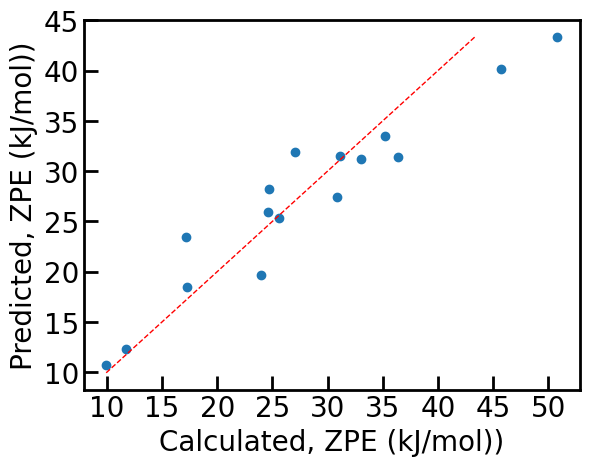

GB 0.7491159887734414
RMSE:  0.11568116095741829
RMSE unscaled:  5.4109865156764
----------------------------------------


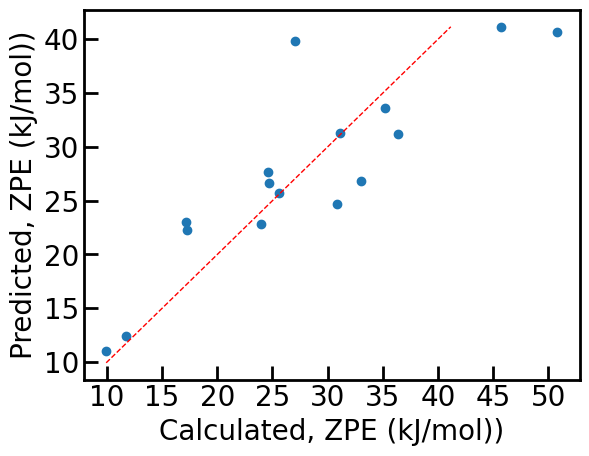

RR 0.8934096336619567
RMSE:  0.07540239204617943
RMSE unscaled:  3.5269470260745903
----------------------------------------


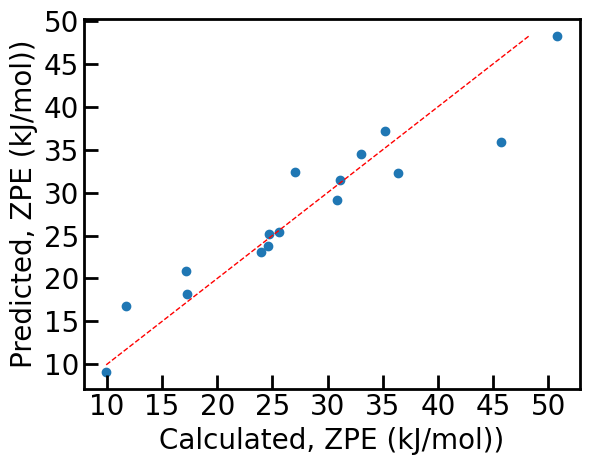

LASSO 0.5747623874105687
RMSE:  0.15060589861635
RMSE unscaled:  7.044591183644565
----------------------------------------


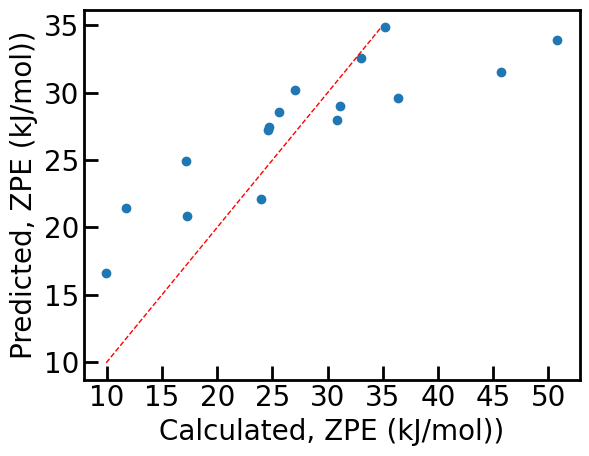

gpr1 0.8755774971662676
RMSE:  0.08146585365667444
RMSE unscaled:  3.8105654540119365
----------------------------------------


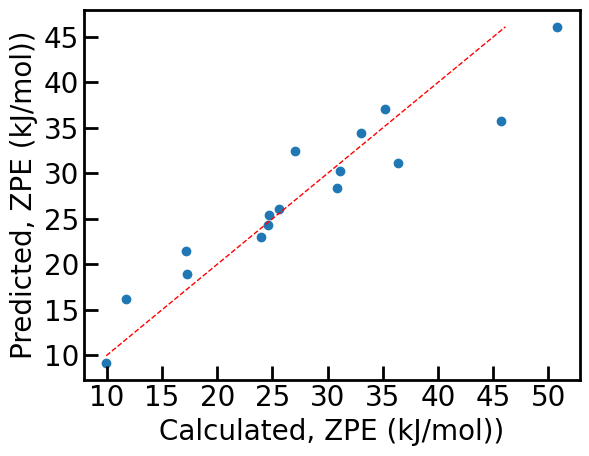

gpr2 -0.043445814327527366
RMSE:  0.23591801028721576
RMSE unscaled:  11.035065363315493
----------------------------------------


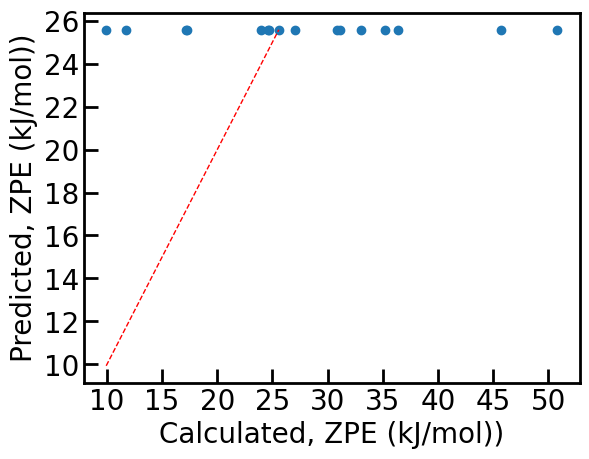

gpr3 0.9364621144119605
RMSE:  0.05821602189711914
RMSE unscaled:  2.7230545308720253
----------------------------------------


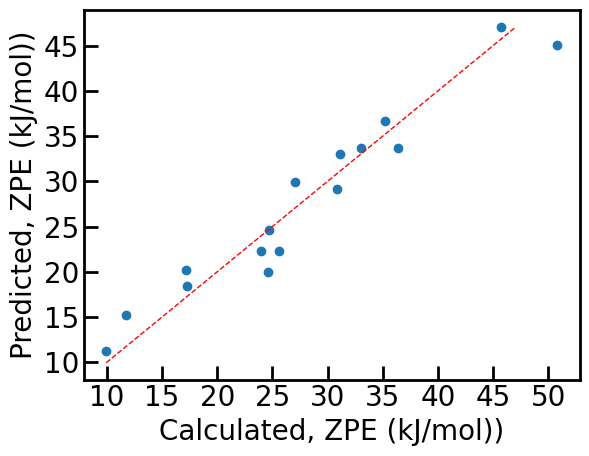

gpr4 0.9130785635077793
RMSE:  0.06809098138147514
RMSE unscaled:  3.184955778840738
----------------------------------------


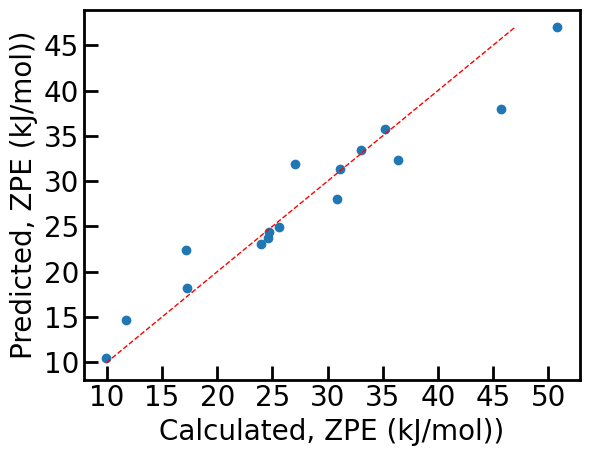

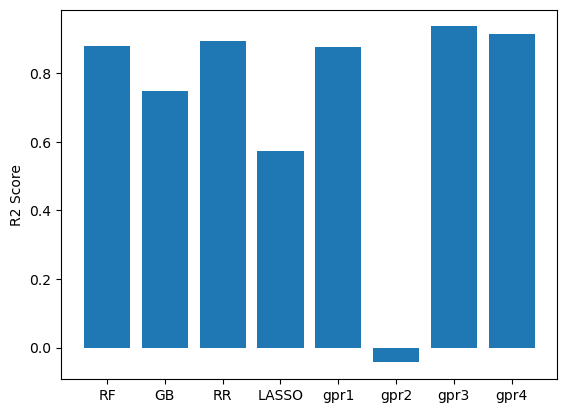

In [45]:
run_models()